# Partial Differential Equations - Stefan problem

# s like surface, h like height and we are flying

### Finite difference method (try)

In [3]:
import numpy as np

In [95]:
def lambd_gen(dx, dt, b=False):
    return dt/(2*(dx**2)) if not b else -dt/(2*(dx**2))

def generate_matrix(dx, dt, M = 10, b=False):
    lambd = lambd_gen(dx, dt, b)
    A = np.zeros((M-1, M-1))
    for i in range(M-1):
        A[i][i] = 1 - 2*lambd
        if 1 <= i < M-1:
            A[i-1][i] = lambd
        if 0 <= i < M-2:
            A[i+1][i] = lambd
    return A

def finite_diff(dx=2, dt=1, M=10):
    u = [0.5]*(M-1)
    u[0] = 0
    u = np.array(u)
    result = np.zeros((M-1, M-1))
    result[0] = u
    A = generate_matrix(dx, dt, M)
    B = generate_matrix(dx, dt, M, True)
    for i in range(1, M-1):
        new_u = np.linalg.inv(B) @ A @ u
        result[i] = new_u
        u = new_u
    return result

def gen_matrixA(M):
    A = np.zeros((M-1, M-1))
    for i in range(M-1):
        A[i][i] = -2
        if 1 <= i < M-1:
            A[i-1][i] = 1
        if 0 <= i < M-2:
            A[i+1][i] = 1
    return A

def gen_matrixB(xs):
    M = len(xs)
    B = np.zeros((M, M))
    for i in range(M):
        if 1 <= i < M:
            B[i-1][i] = xs[i-1]
        if 0 <= i < M-1:
            B[i+1][i] = -xs[i+1]
    return B

def finite_difference_method(t_max, beta=1, M=10, t_0=0):
    ts = np.linspace(t_0, t_max, M-1)
    ksi = np.linspace(0, 1, M-1)
    k = ts[1]-ts[0]
    gamma = abs(1/np.sqrt(beta))
    s = [0, 0] ###NEWTON 3

    A = gen_matrixA(M)
    B = gen_matrixB(ksi)
    I = np.identity(M-1)
    
    f = [-1]*(M-1)
    
    result = np.zeros((M-1, M-1))
    result[0] = f
    
    for i in range(1, len(ts)):
        #eq 3.63 TODO
        h = ts[i]
        A *= 1/(2*h**2)
        B *= 1/(4*h)
        tn_12 = (ts[i]+ts[i-1])/k
        sn_12 = gamma*(ts[i] + ts[i-1])/2
        sn_1 = 
        sn =
        sp = gamma*(ts[i] - ts[i-1])/k
        
        L = tn_12*A - sn_12**2 * (0.5 + tn_12/k)*I + tn_12*sn_12*sp*B
        R = -tn_12*A + sn_12**2 * (0.5 - tn_12/k)*I - tn_12*sn_12*sp*B
        D = np.zeros(M-1)
        D[0] = (tn_12/(2*h**2) - (ksi[0]*tn_12*sn_12*(sn_1*sn)/2)/(4*h))*((np.exp(ts[i])-1)/ts[i] + (np.exp(ts[i-1])-1)/(ts[i-1]))
        
        new_f = np.linalg.inv(L) @ (R @ f + D)
        result[i] = new_f
        f = new_f
    
    return result

In [96]:
gen_matrixB([1, 2, 3, 4, 5, 6])

array([[ 0.,  1.,  0.,  0.,  0.,  0.],
       [-2.,  0.,  2.,  0.,  0.,  0.],
       [ 0., -3.,  0.,  3.,  0.,  0.],
       [ 0.,  0., -4.,  0.,  4.,  0.],
       [ 0.,  0.,  0., -5.,  0.,  5.],
       [ 0.,  0.,  0.,  0., -6.,  0.]])

In [97]:
finite_difference_method(10)

9 9 9
9 9 9
9 9 9
9 9 9
9 9 9
9 9 9
9 9 9
9 9 9


array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        ],
       [ 0.14244661, -0.12284533, -0.20014328, -0.2194103 , -0.21803136,
        -0.20019206, -0.15035258, -0.02440027,  0.28145228],
       [ 0.08832999, -0.07897401, -0.13084141, -0.14361322, -0.1424573 ,
        -0.12995696, -0.0950622 , -0.00710084,  0.1775942 ],
       [ 0.06865404, -0.06142607, -0.10177196, -0.11170028, -0.11079227,
        -0.10104852, -0.07384976, -0.0053041 ,  0.13806803],
       [ 0.05739888, -0.05135672, -0.08508838, -0.09338884, -0.09262942,
        -0.08448241, -0.06174086, -0.00442847,  0.11543354],
       [ 0.04994448, -0.04468704, -0.07403795, -0.08126043, -0.08059962,
        -0.07351065, -0.0537225 , -0.00385319,  0.10044217],
       [ 0.04457411, -0.03988198, -0.06607688, -0.07252275, -0.07193299,
        -0.06560628, -0.04794589, -0.00343886,  0.08964194],
       [ 0.04048474, -0.03622308, -0.06001478, -0.06586928, -0

In [66]:
xc[0] = [1, 2, 4, 5, 6]

In [67]:
np.arange(0, 2*9, 2)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16])

## useful

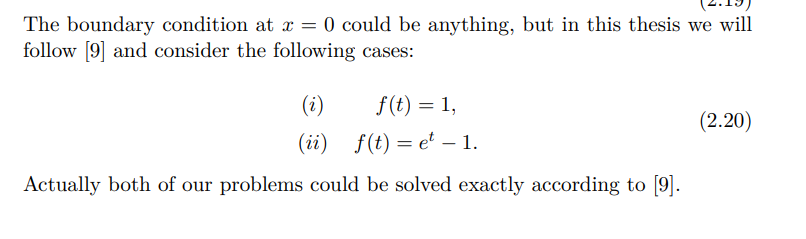

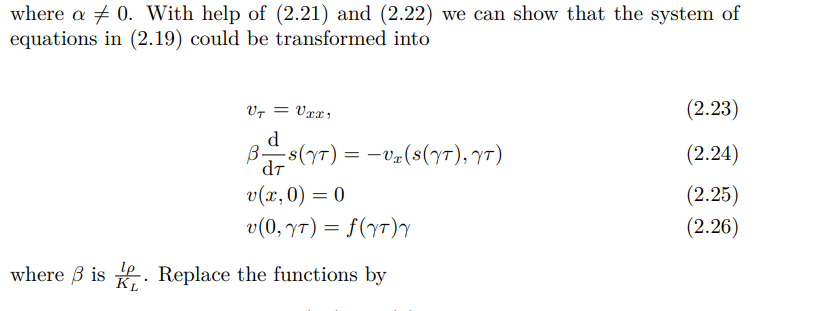

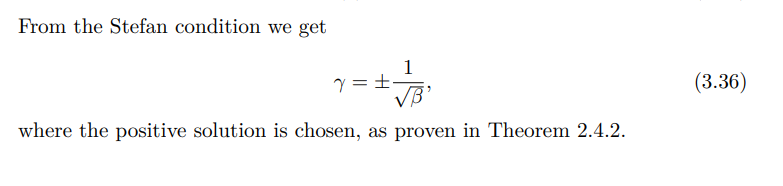

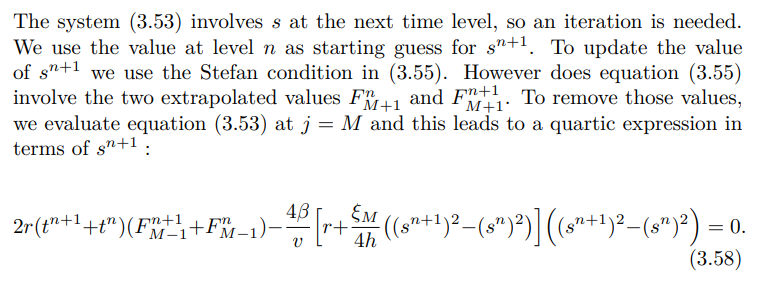